In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Carico il dataset
data = pd.read_csv("https://raw.githubusercontent.com/Profession-AI/progetti-ml/refs/heads/main/Analizza%20il%20sentiment%20delle%20notizie%20finanziarie%20su%20un%20titolo/Full_FinanceTech_Corp_Tweets_Dataset.csv")
sentiments = data['sentiment']
print(f"Dataset caricato: {data.shape[0]} tweet")
print(f"\nPrime righe:\n{data.head()}")

# Conto il numero di sentiment positivi e negativi per valutare il dataset
sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)
sentiment_pct = data['sentiment'].value_counts(normalize=True) * 100
for sentiment, pct in sentiment_pct.items():
    print(f"{sentiment}: {sentiment_counts[sentiment]} tweet ({pct:.1f}%)")
print('Il dataset risulta già bilanciato senza casi neutri.')

Dataset caricato: 1000 tweet

Prime righe:
                                               tweet sentiment
0  FinanceTech Corp highlight a drop in stock val...  negative
1  The team at FinanceTech announce record-breaki...  positive
2  Investors in FinanceTech are thrilled with str...  positive
3  The team at FinanceTech are disappointed by de...  negative
4  FinanceTech Corp announce positive customer fe...  positive
sentiment
negative    500
positive    500
Name: count, dtype: int64
negative: 500 tweet (50.0%)
positive: 500 tweet (50.0%)
Il dataset risulta già bilanciato senza casi neutri.


In [2]:
# Data cleaning
import nltk
from nltk.corpus import stopwords
import string
import spacy
import re
nltk.download('stopwords', quiet=True)

english_stopwords = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def data_cleaner(sentence):
    # Rimuovo URL
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
    # Rimuovo menzioni
    sentence = re.sub(r'@\w+', '', sentence)
    # Rimuovo hashtag ma mantenendo il testo
    sentence = re.sub(r'#(\w+)', r'\1', sentence)
    # Converto in minuscolo
    sentence = sentence.lower()
    # Rimuovo punteggiatura
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    # Rimuovo i numeri
    sentence = re.sub(r'\d+', '', sentence)
    # Lemmatizzazione
    document = nlp(sentence)
    tokens = [token.lemma_ for token in document if not token.is_space]
    # Rimuovo stopwords
    tokens = [word for word in tokens if word not in english_stopwords]
    # Rimuovo gli spazi extra
    tokens = [word.strip() for word in tokens if word.strip()]
    sentence = ' '.join(tokens)
    return sentence
# Sovrascrivo direttamente la colonna tweet in modo da risparmiare memoria
data['tweet'] = data['tweet'].apply(data_cleaner)
print(f"\nPrime righe dopo la pulizia:")
print(data[['tweet', 'sentiment']].head())


Prime righe dopo la pulizia:
                                               tweet sentiment
0  financetech corp highlight drop stock value te...  negative
1  team financetech announce recordbreake profit ...  positive
2  investor financetech thrill strong quarterly e...  positive
3   team financetech disappoint decline profit stock  negative
4  financetech corp announce positive customer fe...  positive


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Definisco Features (X) e Target (y)
X = data['tweet']
y = data['sentiment']
# Suddivido il dataset in Training 80% e Test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dimensioni del training set: {X_train.shape[0]} tweet")
print(f"Dimensioni del test set: {X_test.shape[0]} tweet")
# TfidfVectorizer con i parametri scelti
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7
)
# Applico il fit_transform sul training set
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Applico il transform sul test set
X_test_tfidf = tfidf_vectorizer.transform(X_test)
# Verifico i risultati
print(f"\nDimensioni della matrice TF-IDF di training: {X_train_tfidf.shape}")
print(f"Dimensioni della matrice TF-IDF di test: {X_test_tfidf.shape}")
# Esempio delle parole/bigrammi create
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nEsempio di 4 feature create: {feature_names[:4]}")
print(f"Ultimi 4 esempi di feature: {feature_names[-4:]}")

Dimensioni del training set: 800 tweet
Dimensioni del test set: 200 tweet

Dimensioni della matrice TF-IDF di training: (800, 238)
Dimensioni della matrice TF-IDF di test: (200, 238)

Esempio di 4 feature create: ['analyst' 'analyst announce' 'analyst celebrate' 'analyst disappoint']
Ultimi 4 esempi di feature: ['value stock' 'value technew' 'weak' 'weak earning']


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

# Controllo dello sbilanciamento delle classi
print("Distribuzione delle classi nel training set:")
train_distribution = y_train.value_counts()
print(train_distribution)
print(f"\nPercentuali:")
print((y_train.value_counts(normalize=True) * 100).round(2))

# Regressione logistica
print("\n")
print("LOGISTIC REGRESSION - MODELLO BASE")
lr_base = LogisticRegression(max_iter=1000, random_state=42)
lr_base.fit(X_train_tfidf, y_train)
y_pred_lr_base = lr_base.predict(X_test_tfidf)
print("\nModello Base (senza bilanciamento):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_base):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_base))

# Regressione logistica questa volta con bilanciamento
print("LOGISTIC REGRESSION - MODELLO BILANCIATO")

# Modello con class_weight='balanced' per gestire lo sbilanciamento
lr_balanced = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    C=1.0
)
lr_balanced.fit(X_train_tfidf, y_train)
y_pred_lr_balanced = lr_balanced.predict(X_test_tfidf)
print("\nModello Balanced (con class_weight='balanced'):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_balanced):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_balanced))

# Confronto tra i due modelli
print("CONFRONTO PRESTAZIONI")
models = {
    'Logistic Regression Base': y_pred_lr_base,
    'Logistic Regression Balanced': y_pred_lr_balanced
}
results = []
for name, predictions in models.items():
    acc = accuracy_score(y_test, predictions)
    f1_macro = f1_score(y_test, predictions, average='macro')
    f1_weighted = f1_score(y_test, predictions, average='weighted')
    results.append({
        'Modello': name,
        'Accuracy': f'{acc:.4f}',
        'F1-Score (Macro)': f'{f1_macro:.4f}',
        'F1-Score (Weighted)': f'{f1_weighted:.4f}'
    })
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print('I risultati sono troppo corretti in entrambi i casi. Il dataset di base non risulta sbilanciato e per questo anche nelle distribuzioni non essendoci differenze non si riscontrano differenze nei modelli.')

Distribuzione delle classi nel training set:
sentiment
positive    400
negative    400
Name: count, dtype: int64

Percentuali:
sentiment
positive    50.0
negative    50.0
Name: proportion, dtype: float64


LOGISTIC REGRESSION - MODELLO BASE

Modello Base (senza bilanciamento):
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       100
    positive       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

LOGISTIC REGRESSION - MODELLO BILANCIATO

Modello Balanced (con class_weight='balanced'):
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       100
    positive       1.00      1.00      1.00       100

    accuracy                           1.00       200
   ma



MATRICE DI CONFUSIONE

Matrice di confusione (array):
[[100   0]
 [  0 100]]


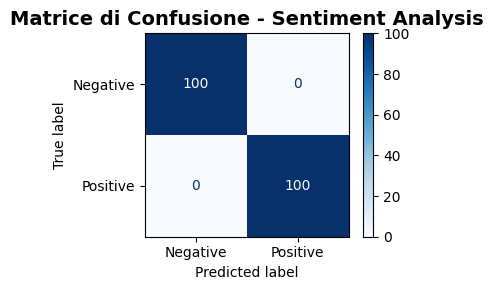



CURVE ROC E AUC SCORE

ROC AUC Score: 1.0000


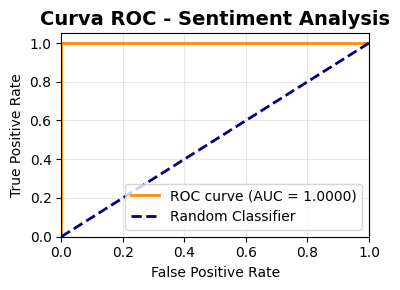



DISTRIBUZIONE DEI SENTIMENT


/tmp/ipython-input-1182703628.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Negative', 'Positive'])
/tmp/ipython-input-1182703628.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Negative', 'Positive'])


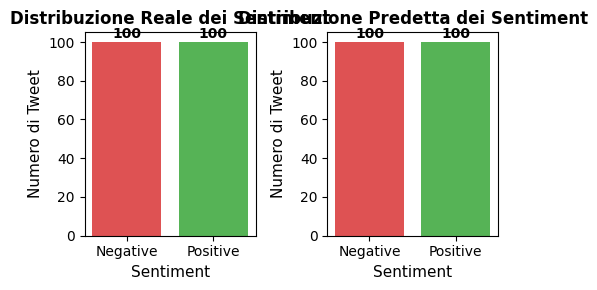



ERROR ANALYSIS - CAMPIONI MAL CLASSIFICATI

Numero di campioni mal classificati: 0
Percentuale di errore: 0.00%

✓ Nessun errore di classificazione! Il modello ha performance perfette.


ANALISI DELLE FEATURE PIÙ IMPORTANTI

Top 15 Feature che indicano Sentiment POSITIVO:
                 Feature  Coefficient
215           successful     2.496185
216   successful product     2.496185
83             expansion     2.387809
149     market expansion     2.387809
172         recordbreake     2.356205
173  recordbreake profit     2.356205
170            quarterly     1.647297
171    quarterly earning     1.647297
206               strong     1.647297
207     strong quarterly     1.647297
154                price     1.639815
204          stock price     1.639815
217                surge     1.639815
218          surge stock     1.639815
22             celebrate     1.591658

Top 15 Feature che indicano Sentiment NEGATIVO:
                Feature  Coefficient
97                 fail    -2.4

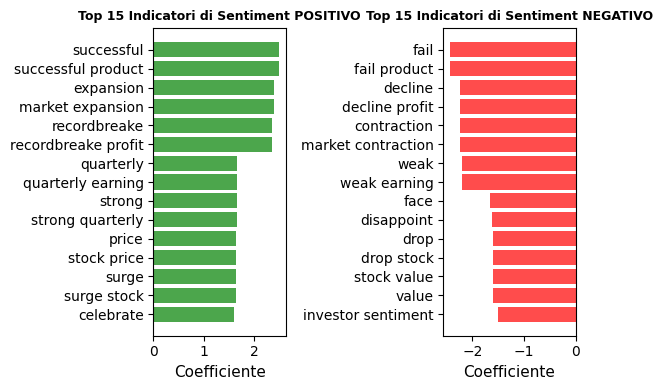

In [9]:
# Analisi dei risultati
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score,
    auc
)
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

# Sceglie il modello migliore in base ai risultati. Anche se nel nostro caso è superfluo
best_model = lr_balanced
y_pred = best_model.predict(X_test_tfidf)

# Metriche di confusione
print("\n")
print("MATRICE DI CONFUSIONE")

# Calcolo la matrice di confusione
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice di confusione (array):")
print(cm)

# Grafico della matrice
fig, ax = plt.subplots(figsize=(4, 3), dpi=100)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Negative', 'Positive']
)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Matrice di Confusione - Sentiment Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Curve ROC e AUC
print("\n")
print("CURVE ROC E AUC SCORE")

# Per classificazione binaria
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test_tfidf)[:, 1]
elif hasattr(best_model, 'decision_function'):
    y_proba = best_model.decision_function(X_test_tfidf)
else:
    print("Il modello non supporta predict_proba o decision_function")
    y_proba = None

if y_proba is not None:
    # Binarizza le label per calcolare ROC
    y_test_binary = label_binarize(y_test, classes=['negative', 'positive'])

    # Calcola FPR, TPR e soglie
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"\nROC AUC Score: {roc_auc:.4f}")

    # Grafico della curva ROC
    plt.figure(figsize=(4, 3), dpi=100)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Curva ROC - Sentiment Analysis', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Distribuzione dei sentiment
print("\n")
print("DISTRIBUZIONE DEI SENTIMENT")

# Confronto tra distribuzione reale e predetta
fig, axes = plt.subplots(1, 2, figsize=(5, 3), dpi=100)

# Distribuzione reale
y_test_counts = pd.Series(y_test).value_counts()
axes[0].bar(y_test_counts.index, y_test_counts.values, color=['#d62728', '#2ca02c'], alpha=0.8)
axes[0].set_title('Distribuzione Reale dei Sentiment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=11)
axes[0].set_ylabel('Numero di Tweet', fontsize=11)
axes[0].set_xticklabels(['Negative', 'Positive'])
for i, v in enumerate(y_test_counts.values):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Distribuzione predetta
y_pred_counts = pd.Series(y_pred).value_counts()
axes[1].bar(y_pred_counts.index, y_pred_counts.values, color=['#d62728', '#2ca02c'], alpha=0.8)
axes[1].set_title('Distribuzione Predetta dei Sentiment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sentiment', fontsize=11)
axes[1].set_ylabel('Numero di Tweet', fontsize=11)
axes[1].set_xticklabels(['Negative', 'Positive'])
for i, v in enumerate(y_pred_counts.values):
    axes[1].text(i, v + 2, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# 5. ERROR ANALYSIS - CAMPIONI MAL CLASSIFICATI
print("\n")
print("ERROR ANALYSIS - CAMPIONI MAL CLASSIFICATI")

# Identifica gli indici dei campioni mal classificati
misclassified_indices = np.where(y_test.values != y_pred)[0]
print(f"\nNumero di campioni mal classificati: {len(misclassified_indices)}")
print(f"Percentuale di errore: {(len(misclassified_indices)/len(y_test))*100:.2f}%")

# Crea un DataFrame con i campioni mal classificati
if len(misclassified_indices) > 0:
    misclassified_df = pd.DataFrame({
        'Tweet': X_test.iloc[misclassified_indices].values,
        'Sentiment Reale': y_test.iloc[misclassified_indices].values,
        'Sentiment Predetto': y_pred[misclassified_indices]
    })
    print("\n" + "-"*60)
    print("PRIMI 10 ESEMPI DI ERRORI DI CLASSIFICAZIONE:")
    print("-"*60)

    # Mostra i primi 10 errori
    for idx, row in misclassified_df.head(10).iterrows():
        print(f"\nTweet #{idx}:")
        print(f"Testo: {row['Tweet']}")
        print(f"Sentiment Reale: {row['Sentiment Reale']}")
        print(f"Sentiment Predetto: {row['Sentiment Predetto']}")
        print("-"*60)

    # Analisi degli errori per tipo
    error_types = misclassified_df.groupby(['Sentiment Reale', 'Sentiment Predetto']).size()
    print("\n" + "="*60)
    print("ANALISI DEGLI ERRORI PER TIPOLOGIA")
    print("="*60)
    print(error_types)

    # Visualizza la distribuzione degli errori
    if len(error_types) > 0:
        plt.figure(figsize=(10, 6), dpi=100)
        error_labels = [f"{real} → {pred}" for (real, pred) in error_types.index]
        plt.bar(error_labels, error_types.values, color=['#ff7f0e', '#1f77b4'], alpha=0.8)
        plt.xlabel('Tipo di Errore (Reale → Predetto)', fontsize=12, fontweight='bold')
        plt.ylabel('Numero di Errori', fontsize=12, fontweight='bold')
        plt.title('Distribuzione degli Errori di Classificazione', fontsize=14, fontweight='bold')
        for i, v in enumerate(error_types.values):
            plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("\n✓ Nessun errore di classificazione! Il modello ha performance perfette.")

# Feature più importanti
print("\n")
print("ANALISI DELLE FEATURE PIÙ IMPORTANTI")

if hasattr(best_model, 'coef_'):
    # Estrai i coefficienti del modello
    feature_names = tfidf_vectorizer.get_feature_names_out()
    coefficients = best_model.coef_[0]

    # Crea un DataFrame con feature e coefficienti
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Top 15 feature positive (indicano sentiment positivo)
    top_positive = feature_importance.nlargest(15, 'Coefficient')
    print("\nTop 15 Feature che indicano Sentiment POSITIVO:")
    print(top_positive)

    # Top 15 feature negative (indicano sentiment negativo)
    top_negative = feature_importance.nsmallest(15, 'Coefficient')
    print("\nTop 15 Feature che indicano Sentiment NEGATIVO:")
    print(top_negative)

    # Visualizzazione
    fig, axes = plt.subplots(1, 2, figsize=(6, 4), dpi=100)

    # Feature positive
    axes[0].barh(top_positive['Feature'], top_positive['Coefficient'], color='green', alpha=0.7)
    axes[0].set_xlabel('Coefficiente', fontsize=11)
    axes[0].set_title('Top 15 Indicatori di Sentiment POSITIVO', fontsize=9, fontweight='bold')
    axes[0].invert_yaxis()

    # Feature negative
    axes[1].barh(top_negative['Feature'], top_negative['Coefficient'], color='red', alpha=0.7)
    axes[1].set_xlabel('Coefficiente', fontsize=11)
    axes[1].set_title('Top 15 Indicatori di Sentiment NEGATIVO', fontsize=9, fontweight='bold')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()


